In [82]:
# For part 1 (data collection and preprocessing)
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# For part 2 (undersampling via stratified SRS)
from sklearn.feature_selection import mutual_info_classif
from sklearn.utils import resample
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture

# For part 3 (classificaiton and prediction)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import check_random_state
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, auc
import seaborn as sns

In [2]:
def classification_and_evaluation(df, baseline=None):
    X = df.drop(columns=['y'])  # Features
    y = df['y']   

    # set random seed for code reproducability

    # 1. data splitting into train-test-validation split (80-10-10)
    # first split train as 80%, rest 20%
    X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=42)
    print(X_train.shape)

    # # split the remaining 20% by half (10% test, 10% validation)
    # X_val, X_test, y_val, y_test=train_test_split(X_test,y_test,test_size=0.5,random_state=7)

# specifically for baseline
    if baseline:
        print("BASELINE!")

        # For Random undersampling
        if baseline[0]=='R':
            # Initialize RandomUnderSampler
            rus = RandomUnderSampler(random_state=42)
            # Apply random undersampling
            X_train, y_train = rus.fit_resample(X_train, y_train)
            print(X_train.shape)

        # For NearMiss
        elif baseline[0]=='N':
            # Initialize NearMiss
            nm = NearMiss(version=1)  # You can experiment with version=2 or 3 for different strategies

            # Apply NearMiss undersampling
            X_train, y_train = nm.fit_resample(X_train, y_train)
            print(X_train.shape)
        
        # For Tomek Links
        elif baseline[0]=='T':
            # Initialize TomekLinks
            tl = TomekLinks()

            # Apply Tomek Links undersampling
            X_train, y_train = tl.fit_resample(X_train, y_train)
            print(X_train.shape)


    # 2. train and fit a decision tree model using the training data
    RF = RandomForestClassifier(random_state=42)
    RF.fit(X_train, y_train)

    # 2.1 make predictions on the testing data based on the pre-tuned model fitted with training data
    RF_y_train_pred=RF.predict(X_test)
    # Accuracy Score, they are around 85-90%
    print("Training (Pre-tuned) Accuracy on Decision Tree: {}".format(accuracy_score(y_test, RF_y_train_pred)))

    # print evaluation
    evaluate_model(y_test, RF_y_train_pred)

In [3]:
def evaluate_model(y_true, y_pred):
    """
    Evaluates a classification model by printing the confusion matrix, 
    classification report, class-wise metrics, and plotting the AUC-ROC 
    and precision-recall curves.
    
    Parameters:
        y_true (array-like): Actual labels
        y_pred (array-like): Predicted probabilities or labels
    """
    # Handle binary or probabilistic predictions
    y_pred_labels = np.where(y_pred >= 0.5, 1, 0) if y_pred.ndim == 1 else np.argmax(y_pred, axis=1)

    # Confusion Matrix
    print("Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred_labels)
    print(cm)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap='coolwarm', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
    plt.title('Confusion Matrix')
    plt.tight_layout()
    # plt.savefig("RF_confusion_matrix.png")


    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_labels))

    # Class-wise Performance Metrics
    classification_report_2 = classification_report(y_true, y_pred_labels, output_dict=True)
    metrics = ['precision', 'recall', 'f1-score']
    class_metrics = {metric: [classification_report_2[class_name][metric] for class_name in ['0','1']] for metric in metrics}
    plt.figure(figsize=(10, 6))
    sns.heatmap(data=pd.DataFrame(class_metrics, index=['No','Yes']), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Class-wise Performance Metrics')
    plt.xlabel('Metrics')
    plt.ylabel('Classes')
    # plt.savefig("RF_performance_metrics.png")
    plt.show()

    
    # AUC-ROC Curve
    if len(np.unique(y_true)) == 2:  # Binary classification
        roc_auc = roc_auc_score(y_true, y_pred)
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        plt.figure(figsize=(10, 5))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("AUC-ROC Curve")
        plt.legend(loc="lower right")
        plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)
    avg_precision = average_precision_score(y_true, y_pred)
    plt.figure(figsize=(10, 5))
    plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.show()

In [73]:
# NOTE: Only put one sampling function at a time
def sampling(df):
    """
    Undersample through maximizing mutual information: (3 parameters 12 VARIANTS)

    parameter 1: num_strata_fixed; is the number of strata fixed or not (2 values: True/ False)
    parameter 2: use_features; either use the data's features or mutual information to determine the number of strata IF num_strata_fixed is true (2 values: True/False)
    parameter 3: allocation; the allocation type use to sample data from each stratum (3 values: 'Neyman', 'Optimal', None)
    """

    # Alex 
    output=sampling_through_mutual_information(df, num_strata_fixed=False, use_features=False, allocation="Neyman")

    return output

In [103]:
# Create a pairwise MI matrix
from sklearn.metrics import mutual_info_score
from sklearn.cluster import AgglomerativeClustering, SpectralClustering
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
from sklearn.manifold import MDS
from joblib import Parallel, delayed

# import numpy as np
def sampling_through_mutual_information(df, num_strata_fixed, use_features, allocation, max_clusters=10):
    """
    Perform stratified undersampling with optional dynamic determination of the number of strata.

    :param df: DataFrame with features and target 'y'.
    :param num_strata_fixed: Boolean indicating whether the number of strata is fixed.
    :param use_features: Flag to decide whether to use all features or mutual information for clustering.
    :param allocation: Allocation type for undersampling (e.g., 'Neyman', 'Optimal', None).
    :param max_clusters: Maximum number of clusters to test when finding optimal strata.
    :return: Balanced DataFrame with undersampled majority class.
    """
    

    # Step 1: Filter majority class samples
    majority_class = df[df['y'] == 0].copy()

    # Step 2: Compute pairwise MI efficiently
    X_majority = majority_class.drop(columns=['y']).values  # Features of majority class
    N = len(X_majority)

    # Define a function for computing entropy of a row
    def compute_entropy(row):
        # Calculate the entropy of a row (sample)
        unique, counts = np.unique(row, return_counts=True)
        probabilities = counts / len(row)
        return -np.sum(probabilities * np.log2(probabilities))

    # Define a function for computing MI for a single row pair and normalizing by entropy
    def compute_mi_row(i, X):
        row_mi = []
        entropy_i = compute_entropy(X[i])
        for j in range(i, N):
            entropy_j = compute_entropy(X[j])
            mi = mutual_info_score(X[i], X[j])
            # Normalize MI by the minimum entropy of the two rows
            mi_normalized = mi / min(entropy_i, entropy_j)
            row_mi.append(mi_normalized)
        return row_mi

    # Use joblib.Parallel to compute MI for each row in parallel
    results = Parallel(n_jobs=2)(delayed(compute_mi_row)(i, X_majority) for i in range(N))

    # Convert results into a symmetric matrix
    mi_matrix = np.zeros((N, N))
    for i, row in enumerate(results):
        mi_matrix[i, i:] = row
        mi_matrix[i:, i] = row  # Fill lower triangle

    print(mi_matrix)


    print("STEP 3:")
    # Step 3: Determine the number of strata (infer from elbow method or SIlhoutette score)
    # Now call the function with your MI matrix
    # MI_matrix = your_MI_matrix  # Replace this with your actual mutual information matrix or dissimilarity matrix
    within_cluster_dissimilarity = elbow_method_for_clusters(mi_matrix)

    # Now call the function with your MI matrix
    # MI_matrix = your_MI_matrix  # Replace this with your actual mutual information matrix or dissimilarity matrix
    silhouette_scores = silhouette_method_for_clusters(mi_matrix)

    # Optionally, print the dissimilarity values for each number of clusters
    for n_clusters, dissim in zip(range(2, 11), within_cluster_dissimilarity):
        print(f"{n_clusters} clusters: {dissim}")

    # ----------------

    best_silhouette_scores=0
    optimal_num_strata=1

    # Optionally, print the silhouette scores for each number of clusters
    for n_clusters, score in zip(range(2, 11), silhouette_scores):
        print(f"{n_clusters} clusters: {score}")
        if score >= best_silhouette_scores:
            best_silhouette_scores=score
            optimal_num_strata=n_clusters

    # Regardless NOW
    # optimal_num_strata = 4
    # print("BEST NUMBER OF STRATA: ", optimal_num_strata)

    # (NEW-PROTO) Step 4: Compare Clustering Methods and Select the Best
    models = {
        "KMeans": KMeans(n_clusters=optimal_num_strata, random_state=42, ),
        "Agglomerative": AgglomerativeClustering(n_clusters=optimal_num_strata),
        "Spectral": SpectralClustering(n_clusters=optimal_num_strata, random_state=42, affinity="precomputed"),
        "GMM": GaussianMixture(n_components=optimal_num_strata, random_state=42),
    }

    results = {}
    for name, model in models.items():
        if name == "Spectral":
            clusters = model.fit_predict(mi_matrix)  # Spectral uses precomputed affinity matrix
        else:
            clusters = model.fit_predict(mi_matrix)
        # Compute all metrics
        silhouette = silhouette_score(mi_matrix, clusters)
        db_index = davies_bouldin_score(mi_matrix, clusters)
        ch_index = calinski_harabasz_score(mi_matrix, clusters)
        results[name] = {
            "Silhouette Score": silhouette,
            "Davies-Bouldin": db_index,
            "Calinski-Harabasz": ch_index,
        }

    # Rank the clustering methods
    ranking = {metric: [] for metric in ["Silhouette Score", "Davies-Bouldin", "Calinski-Harabasz"]}
    for metric in ranking:
        if metric == "Davies-Bouldin":  # Lower is better for Davies-Bouldin
            sorted_methods = sorted(results.items(), key=lambda x: x[1][metric])
        else:  # Higher is better for other metrics
            sorted_methods = sorted(results.items(), key=lambda x: x[1][metric], reverse=True)
        ranking[metric] = [method for method, _ in sorted_methods]

    # Aggregate rankings
    final_scores = {method: 0 for method in results}
    for metric, ranked_methods in ranking.items():
        for rank, method in enumerate(ranked_methods):
            final_scores[method] += rank

    # Select the best method
    best_method = min(final_scores, key=final_scores.get)

    # Display Results
    print("\nClustering Method Comparison:")
    for method, scores in results.items():
        print(f"\nMethod: {method}")
        for metric, score in scores.items():
            print(f"  {metric}: {score:.3f}")

    print("\nRanking by Metrics:")
    for metric, ranked_methods in ranking.items():
        print(f"\nMetric: {metric}")
        print("  " + " > ".join(ranked_methods))

    print("\nOverall Ranking:")
    for method, score in sorted(final_scores.items(), key=lambda x: x[1]):
        print(f"{method}: Rank {score + 1}")

    print(f"\nBest Clustering Method: {best_method}")

    
    # Step 4 (CONTINUED): Group majority class samples into strata using clustering on MI matrix (HERE)

    # "KMeans", "Agglomerative","Spectral", "GMM"

    if best_method=="KMeans":
        # K-means clustering (75.75...)
        print("Chose KMEANS!")
        distance_matrix = 1 - mi_matrix
        mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
        X_mds = mds.fit_transform(distance_matrix)
        kmeans = KMeans(n_clusters=optimal_num_strata, random_state=42)
        majority_class['stratum'] = kmeans.fit_predict(X_mds)

    elif best_method=="Agglomerative":
        print("Chose Linkage!")
        # hierarchial clustering (POOR)
        clustering = AgglomerativeClustering(n_clusters=optimal_num_strata, metric='precomputed', linkage='average')
        majority_class['stratum'] = clustering.fit_predict(1 - mi_matrix)  # Convert similarity to dissimilarity

    elif best_method=="Spectral":
        print("Chose Spectral!")
        # Spectral clustering (SLIGHTLY BETTER)
        spectral = SpectralClustering(n_clusters=optimal_num_strata, affinity='precomputed', random_state=42)
        # majority_class['stratum'] = spectral.fit_predict(1 - mi_matrix)  # Convert similarity to dissimilarity
        majority_class['stratum'] = spectral.fit_predict(mi_matrix)  # Convert similarity to dissimilarity

    elif best_method=="GMM":
        print("Chose GMM!")
        distance_matrix = 1 - mi_matrix
        mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
        X_mds = mds.fit_transform(distance_matrix)
        gmm = GaussianMixture(n_components=optimal_num_strata, random_state=42)
        majority_class['stratum'] = gmm.fit_predict(X_mds)

    print(majority_class['stratum'].value_counts())
    
    

    # Step 5: Perform undersampling on majority class samples

    # Group majority class by stratum
    strata_groups = majority_class.groupby('stratum')
    minority_class_size = len(df[df['y'] == 1])
    allocation='Optimal'
    # Select allocation method
    if allocation == 'Equal':
        sampled_majority_class = equal_allocation(majority_class, strata_groups, minority_class_size)
    elif allocation == 'Neyman':
        sampled_majority_class = neyman_allocation(majority_class, strata_groups, minority_class_size)
    elif allocation == 'Optimal':
        sampled_majority_class = optimal_allocation(majority_class, strata_groups, minority_class_size)
    

    # Step 6: Combine undersampled majority class with the minority class
    minority_class = df[df['y'] == 1]  # Keep all minority class samples
    final_df = pd.concat([sampled_majority_class, minority_class])

    # Shuffle the resulting dataset
    final_df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Drop unneeded columns
    final_df.drop(columns=['stratum'], inplace=True)

    print(final_df['y'].value_counts())

    return final_df

In [6]:
# Equal Allocation
def equal_allocation(majority_class, strata_groups, minority_class_size):
    # minority_class_size = len(df[df['y'] == 1])

    # Group majority class by stratum
    # strata_groups = majority_class.groupby('stratum')

    # Initial Equal Allocation: Sample the same number of samples from each stratum
    samples_per_stratum = minority_class_size // len(strata_groups)
    remaining_samples = minority_class_size - (samples_per_stratum * len(strata_groups))

    sampled_strata = []

    # Perform initial SRS on each stratum with equal allocation
    for stratum, group in strata_groups:
        num_samples_to_sample = min(samples_per_stratum, len(group))  # Ensure we don't sample more than available
        sampled_group = group.sample(n=num_samples_to_sample, random_state=42)
        sampled_strata.append(sampled_group)

    # Keep track of the number of samples we have so far
    sampled_majority_class = pd.concat(sampled_strata, axis=0)

    
    remaining_samples_needed = minority_class_size - len(sampled_majority_class)

    # If there are remaining samples to be drawn, perform SRS again
    while remaining_samples_needed > 0:
        print(f"Remaining samples needed: {remaining_samples_needed}")

        # Find strata that still have samples left to be drawn
        remaining_strata = majority_class.loc[~majority_class.index.isin(sampled_majority_class.index)]

        # Sample from these remaining strata using SRS
        strata_groups_remaining = remaining_strata.groupby('stratum')

        for stratum, group in strata_groups_remaining:
            # If there are still remaining samples in this stratum, sample them
            num_samples_to_sample = min(len(group), remaining_samples_needed)
            sampled_group = group.sample(n=num_samples_to_sample, random_state=42)
            sampled_majority_class = pd.concat([sampled_majority_class, sampled_group], axis=0)
            
            # Reduce remaining samples needed
            remaining_samples_needed -= num_samples_to_sample
            
            # Exit early if no more samples are needed
            if remaining_samples_needed <= 0:
                break
    # # Total number of strata
    # num_strata = len(strata_groups)
    
    # # Samples per stratum
    # samples_per_stratum = minority_class_size // num_strata
    # remaining_samples = minority_class_size - (samples_per_stratum * num_strata)

    # sampled_strata = []

    # # Perform sampling with equal allocation
    # for stratum, group in strata_groups:
    #     num_samples_to_sample = min(samples_per_stratum, len(group))  # Ensure we don't oversample
    #     sampled_group = group.sample(n=num_samples_to_sample, random_state=42)
    #     sampled_strata.append(sampled_group)

    # # Combine sampled strata
    # sampled_majority_class = pd.concat(sampled_strata, axis=0)

    # # Handle remaining samples (if any)
    # remaining_samples_needed = remaining_samples
    # if remaining_samples_needed > 0:
    #     remaining_strata = majority_class.loc[~majority_class.index.isin(sampled_majority_class.index)]
    #     strata_groups_remaining = remaining_strata.groupby('stratum')
    #     for stratum, group in strata_groups_remaining:
    #         num_samples_to_sample = min(len(group), remaining_samples_needed)
    #         sampled_group = group.sample(n=num_samples_to_sample, random_state=42)
    #         sampled_majority_class = pd.concat([sampled_majority_class, sampled_group], axis=0)
    #         remaining_samples_needed -= num_samples_to_sample
    #         if remaining_samples_needed <= 0:
    #             break

    return sampled_majority_class


In [7]:
# Neyman Allocation
def neyman_allocation(majority_class, strata_groups, minority_class_size):
    # Calculate strata sizes (N_h) and variances (S_h)
    strata_info = strata_groups.size().to_frame(name='N_h')
    strata_info['S_h'] = strata_groups.std().mean(axis=1)  # Standard deviation across features

    # Compute weights for Neyman allocation
    strata_info['weight'] = strata_info['N_h'] * strata_info['S_h']

    # Normalize weights to calculate samples per stratum
    strata_info['n_h'] = (strata_info['weight'] / strata_info['weight'].sum()) * minority_class_size
    strata_info['n_h'] = strata_info['n_h'].round().astype(int)  # Round to nearest integer

    # Sample from each stratum based on calculated n_h
    sampled_strata = []
    for stratum, group in strata_groups:
        num_samples_to_sample = min(strata_info.loc[stratum, 'n_h'], len(group))  # Ensure we don't oversample
        sampled_group = group.sample(n=num_samples_to_sample, random_state=42)
        sampled_strata.append(sampled_group)

    # Combine all sampled strata
    sampled_majority_class = pd.concat(sampled_strata, axis=0)

    # Handle remaining samples (if minority_class_size isn't met due to rounding or small strata)
    remaining_samples_needed = minority_class_size - len(sampled_majority_class)
    if remaining_samples_needed > 0:
        remaining_strata = majority_class.loc[~majority_class.index.isin(sampled_majority_class.index)]
        strata_groups_remaining = remaining_strata.groupby('stratum')
        for stratum, group in strata_groups_remaining:
            num_samples_to_sample = min(len(group), remaining_samples_needed)
            sampled_group = group.sample(n=num_samples_to_sample, random_state=42)
            sampled_majority_class = pd.concat([sampled_majority_class, sampled_group], axis=0)
            remaining_samples_needed -= num_samples_to_sample
            if remaining_samples_needed <= 0:
                break

    return sampled_majority_class


In [8]:
# Optimal Allocation
def optimal_allocation(majority_class, strata_groups, minority_class_size, costs=None):
    # Calculate strata sizes (N_h) and variances (S_h)
    strata_info = strata_groups.size().to_frame(name='N_h')
    strata_info['S_h'] = strata_groups.std().mean(axis=1)  # Standard deviation across features

    # If costs are not provided, set them to 1 for all strata
    # if costs is None:
    #     strata_info['C_h'] = 1
    # else:
    #     strata_info['C_h'] = costs

    factor=5

    # Define non-uniform cost (penalize larger strata)
    strata_info = strata_info.sort_values(by='N_h')
    strata_info['C_h'] = factor ** (strata_info.index.to_series().rank() - 1)  # Costs: 1, 10, 100, ...


    # Compute weights for Optimal allocation
    strata_info['weight'] = strata_info['N_h'] * strata_info['S_h'] / strata_info['C_h']

    # Normalize weights to calculate samples per stratum
    strata_info['n_h'] = (strata_info['weight'] / strata_info['weight'].sum()) * minority_class_size
    strata_info['n_h'] = strata_info['n_h'].round().astype(int)  # Round to nearest integer

    # Sample from each stratum based on calculated n_h
    sampled_strata = []
    for stratum, group in strata_groups:
        num_samples_to_sample = min(strata_info.loc[stratum, 'n_h'], len(group))  # Ensure we don't oversample
        sampled_group = group.sample(n=num_samples_to_sample, random_state=42)
        sampled_strata.append(sampled_group)

    # Combine all sampled strata
    sampled_majority_class = pd.concat(sampled_strata, axis=0)

    # Handle remaining samples (if minority_class_size isn't met due to rounding or small strata)
    remaining_samples_needed = minority_class_size - len(sampled_majority_class)
    if remaining_samples_needed > 0:
        remaining_strata = majority_class.loc[~majority_class.index.isin(sampled_majority_class.index)]
        strata_groups_remaining = remaining_strata.groupby('stratum')
        for stratum, group in strata_groups_remaining:
            num_samples_to_sample = min(len(group), remaining_samples_needed)
            sampled_group = group.sample(n=num_samples_to_sample, random_state=42)
            sampled_majority_class = pd.concat([sampled_majority_class, sampled_group], axis=0)
            remaining_samples_needed -= num_samples_to_sample
            if remaining_samples_needed <= 0:
                break

    return sampled_majority_class


In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster

def elbow_method_for_clusters(MI_matrix, max_clusters=20):

    # Convert MI matrix to a dissimilarity matrix by doing 1 - MI matrix
    dissimilarity_matrix = 1 - MI_matrix

    # Step 1: Compute hierarchical clustering using the dissimilarity matrix
    # Perform hierarchical clustering (Ward's method is a good choice for minimizing variance)
    Z = linkage(dissimilarity_matrix, method='ward')

    # Step 2: Compute within-cluster dissimilarity for different cluster numbers
    within_cluster_dissimilarity = []

    for n_clusters in range(2, max_clusters + 1):
        # Cut the hierarchical tree to form 'n_clusters' clusters
        clusters = fcluster(Z, n_clusters, criterion='maxclust')
        
        # Step 3: Compute the within-cluster dissimilarity (sum of pairwise distances within each cluster)
        dissimilarity = 0
        for cluster in set(clusters):
            cluster_indices = np.where(clusters == cluster)[0]
            cluster_points = dissimilarity_matrix[cluster_indices, :][:, cluster_indices]  # Submatrix of points in the same cluster
            dissimilarity += np.sum(pdist(cluster_points))  # Pairwise distance within cluster
        
        # Step 4: Store the within-cluster dissimilarity for the current number of clusters
        within_cluster_dissimilarity.append(dissimilarity)

    # Step 5: Plot the dissimilarity vs. number of clusters
    plt.figure(figsize=(8, 6))
    plt.plot(range(2, max_clusters + 1), within_cluster_dissimilarity, marker='o')
    plt.xlabel('Number of clusters')
    plt.xticks(np.arange(0, max_clusters+1, step=2))
    plt.ylabel('Within-cluster dissimilarity')
    plt.title('Elbow Method for Hierarchical Clustering')
    plt.grid(True)
    plt.show()

    # Return the dissimilarity values for each number of clusters
    return within_cluster_dissimilarity

# # Now call the function with your MI matrix
# # MI_matrix = your_MI_matrix  # Replace this with your actual mutual information matrix or dissimilarity matrix
# within_cluster_dissimilarity = elbow_method_for_clusters(MI_matrix)

# # Optionally, print the dissimilarity values for each number of clusters
# for n_clusters, dissim in zip(range(2, 11), within_cluster_dissimilarity):
#     print(f"{n_clusters} clusters: {dissim}")


In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score

def silhouette_method_for_clusters(MI_matrix, max_clusters=20):
    # Convert MI matrix to a dissimilarity matrix by doing its complement
    dissimilarity_matrix = 1 - MI_matrix

    # Step 1: Compute hierarchical clustering using the dissimilarity matrix
    # Perform hierarchical clustering (Ward's method is a good choice for minimizing variance)
    Z = linkage(dissimilarity_matrix, method='ward')

    # Step 2: Store silhouette scores for different cluster numbers
    silhouette_scores = []

    for n_clusters in range(2, max_clusters + 1):
        # Cut the hierarchical tree to form 'n_clusters' clusters
        clusters = fcluster(Z, n_clusters, criterion='maxclust')

        # Step 3: Calculate the silhouette score for the current number of clusters
        # Use the silhouette_score function to calculate the silhouette score for clustering
        score = silhouette_score(dissimilarity_matrix, clusters, metric='euclidean')
        
        # Step 4: Store the silhouette score for the current number of clusters
        silhouette_scores.append(score)

    # Step 5: Plot the silhouette score vs. number of clusters
    plt.figure(figsize=(8, 6))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.xticks(np.arange(0, max_clusters+1, step=2))
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Method for Hierarchical Clustering')
    plt.grid(True)
    plt.show()

    # Return the silhouette scores for each number of clusters
    return silhouette_scores

# Now call the function with your MI matrix
# MI_matrix = your_MI_matrix  # Replace this with your actual mutual information matrix or dissimilarity matrix
# silhouette_scores = silhouette_method_for_clusters(MI_matrix)

# Optionally, print the silhouette scores for each number of clusters
# for n_clusters, score in zip(range(2, 11), silhouette_scores):
#     print(f"{n_clusters} clusters: {score}")


# Experiment

In [57]:
data_path="https://raw.githubusercontent.com/Alex-Mak-MCW/Data_Sampling_Project/refs/heads/main/processed_breast_cancer_data.csv"

# data_path="https://raw.githubusercontent.com/Alex-Mak-MCW/Data_Sampling_Project/refs/heads/main/Processed_Input.csv"


data=pd.read_csv(data_path)

In [11]:
# data['poutcome']=data['poutcome']*2

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272 entries, 0 to 271
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   age                    272 non-null    int64
 1   menopause              272 non-null    int64
 2   tumor-size             272 non-null    int64
 3   inv-nodes              272 non-null    int64
 4   node-caps              272 non-null    int64
 5   deg-malig              272 non-null    int64
 6   irradiat               272 non-null    int64
 7   y                      272 non-null    int64
 8   breast_left            272 non-null    int64
 9   breast_right           272 non-null    int64
 10  breast-quad_central    272 non-null    int64
 11  breast-quad_left_low   272 non-null    int64
 12  breast-quad_left_up    272 non-null    int64
 13  breast-quad_right_low  272 non-null    int64
 14  breast-quad_right_up   272 non-null    int64
dtypes: int64(15)
memory usage: 32.0 KB


In [59]:
data

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,irradiat,y,breast_left,breast_right,breast-quad_central,breast-quad_left_low,breast-quad_left_up,breast-quad_right_low,breast-quad_right_up
0,2,2,6,0,0,3,0,0,1,0,0,1,0,0,0
1,3,2,4,0,0,2,0,0,0,1,0,0,0,0,1
2,3,2,4,0,0,2,0,0,1,0,0,1,0,0,0
3,5,1,3,0,0,2,0,0,0,1,0,0,1,0,0
4,3,2,0,0,0,2,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,2,2,6,0,0,2,0,1,1,0,0,0,1,0,0
268,2,2,4,0,0,3,1,1,1,0,0,0,1,0,0
269,5,1,4,0,0,1,0,1,0,1,0,0,1,0,0
270,3,1,6,1,0,3,0,1,1,0,0,1,0,0,0


[[0.69314718 0.46056675 0.63835937 ... 0.39852879 0.63667457 0.43650672]
 [0.46056675 0.69314718 0.51535456 ... 0.44333076 0.45341457 0.43650672]
 [0.63835937 0.51535456 0.69314718 ... 0.39852879 0.63667457 0.43650672]
 ...
 [0.39852879 0.44333076 0.39852879 ... 0.69314718 0.38946887 0.4128086 ]
 [0.63667457 0.45341457 0.63667457 ... 0.38946887 0.69314718 0.41330084]
 [0.43650672 0.43650672 0.43650672 ... 0.4128086  0.41330084 0.69314718]]
STEP 3:


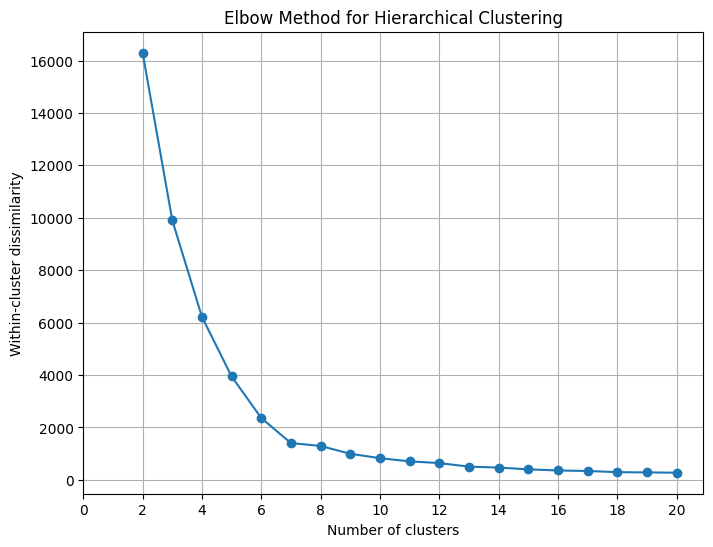

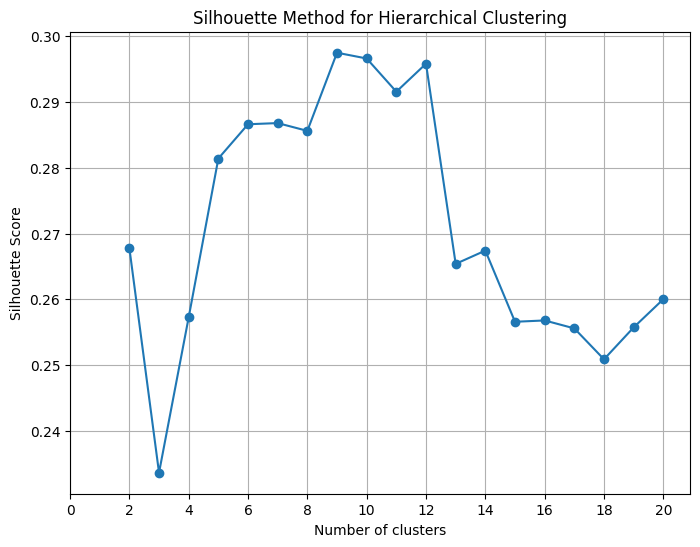

2 clusters: 16298.189424647042
3 clusters: 9908.790385102602
4 clusters: 6219.616907782186
5 clusters: 3945.271015011468
6 clusters: 2359.878623388415
7 clusters: 1403.456413511699
8 clusters: 1294.0510225515955
9 clusters: 995.2978280839646
10 clusters: 827.601802053413
2 clusters: 0.26780470898772396
3 clusters: 0.23366654382542024
4 clusters: 0.2572767880602807
5 clusters: 0.2814016720480302
6 clusters: 0.2866064811543195
7 clusters: 0.28678359744164517
8 clusters: 0.2856020144145362
9 clusters: 0.29747393212916196
10 clusters: 0.2965978728897561

Clustering Method Comparison:

Method: KMeans
  Silhouette Score: 0.295
  Davies-Bouldin: 1.551
  Calinski-Harabasz: 42.474

Method: Agglomerative
  Silhouette Score: 0.297
  Davies-Bouldin: 1.538
  Calinski-Harabasz: 40.194

Method: Spectral
  Silhouette Score: 0.308
  Davies-Bouldin: 1.603
  Calinski-Harabasz: 33.307

Method: GMM
  Silhouette Score: 0.295
  Davies-Bouldin: 1.551
  Calinski-Harabasz: 42.474

Ranking by Metrics:

Metric: S

In [104]:
resampled_data=sampling(data)

In [105]:
print("DONE!")
resampled_data

DONE!


,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,irradiat,y,breast_left,breast_right,breast-quad_central,breast-quad_left_low,breast-quad_left_up,breast-quad_right_low,breast-quad_right_up
0,2,2,4,0,0,3,1,1,1,0,0,0,1,0,0
1,4,2,10,3,1,2,0,1,0,1,0,0,1,0,0
2,5,1,10,0,0,3,0,1,0,1,0,0,1,0,0
3,4,1,3,0,1,2,1,0,1,0,1,0,0,0,0
4,3,1,4,0,0,2,0,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,4,1,0,0,0,1,0,0,0,1,1,0,0,0,0
158,4,2,6,0,0,3,1,1,0,1,0,0,1,0,0
159,3,2,5,0,0,2,0,0,1,0,0,0,1,0,0
160,4,2,5,0,0,1,0,1,0,1,0,0,1,0,0


(129, 14)
Training (Pre-tuned) Accuracy on Decision Tree: 0.7575757575757576
Confusion Matrix:
[[15  5]
 [ 3 10]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.75      0.79        20
           1       0.67      0.77      0.71        13

    accuracy                           0.76        33
   macro avg       0.75      0.76      0.75        33
weighted avg       0.77      0.76      0.76        33



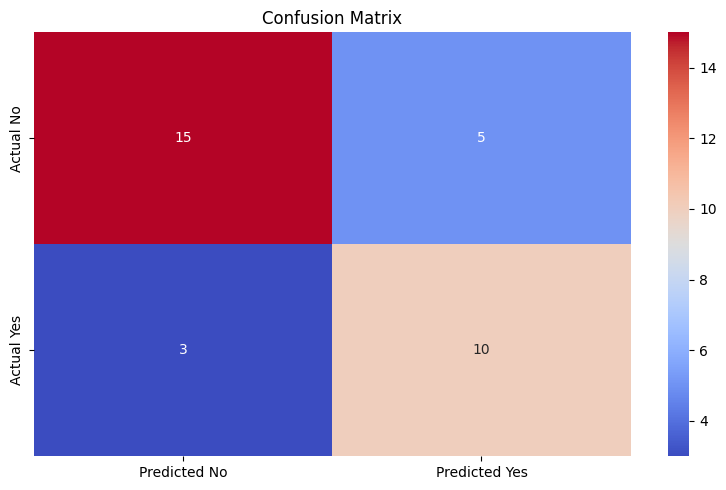

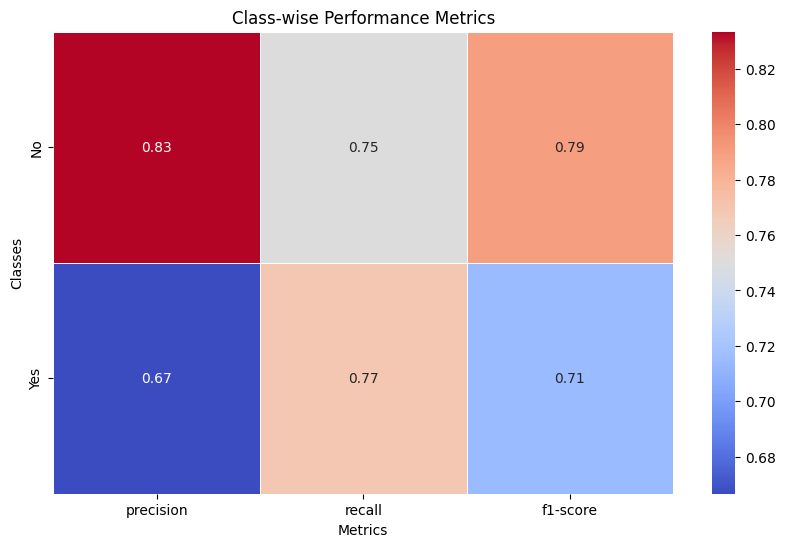

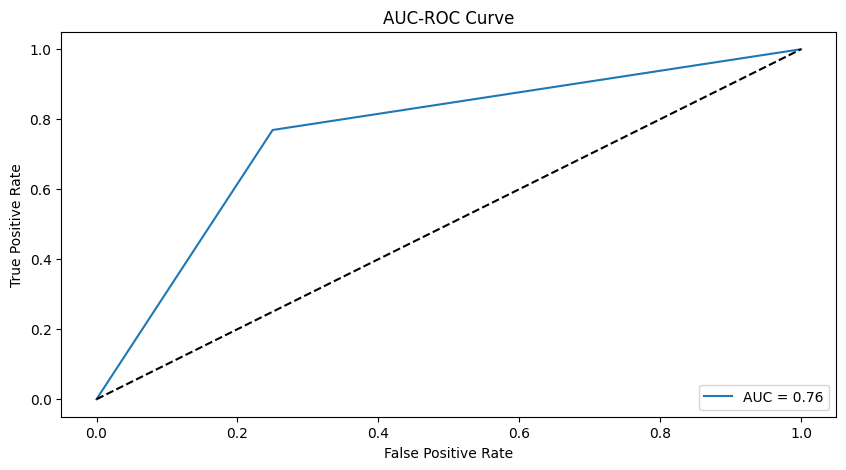

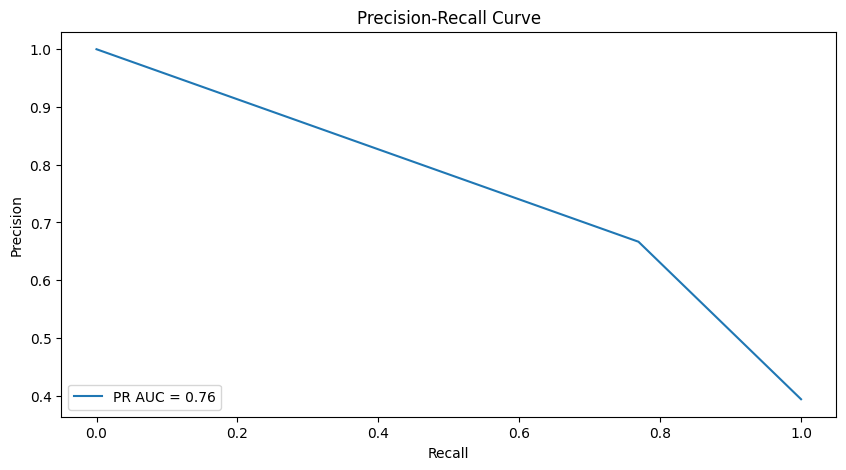

In [106]:
classification_and_evaluation(resampled_data)

In [30]:
# # Create a pairwise MI matrix
# from sklearn.metrics import mutual_info_score
# from sklearn.cluster import AgglomerativeClustering, SpectralClustering
# from scipy.cluster.hierarchy import linkage, fcluster
# from scipy.spatial.distance import pdist
# # import numpy as np
# def sampling_through_mutual_information(df, num_strata_fixed, use_features, allocation, max_clusters=10):
#     """
#     Perform stratified undersampling with optional dynamic determination of the number of strata.

#     :param df: DataFrame with features and target 'y'.
#     :param num_strata_fixed: Boolean indicating whether the number of strata is fixed.
#     :param use_features: Flag to decide whether to use all features or mutual information for clustering.
#     :param allocation: Allocation type for undersampling (e.g., 'Neyman', 'Optimal', None).
#     :param max_clusters: Maximum number of clusters to test when finding optimal strata.
#     :return: Balanced DataFrame with undersampled majority class.
#     """
    

#     # Step 1: Filter majority class samples for MI calculation and stratification (OK)
#     majority_class = df[df['y'] == 0].copy()

#     # Step 2: Compute pairwise MI between majority class samples (OK)
#     X_majority = majority_class.drop(columns=['y']).values  # Features of majority class
#     N = len(X_majority)

#     mi_matrix = np.zeros((N, N))
#     for i in range(N):
#         for j in range(i, N):
#             mi = mutual_info_score(X_majority[i], X_majority[j])
#             mi_matrix[i, j] = mi
#             mi_matrix[j, i] = mi  # Symmetric matrix

    
#     # Step 3: Determine the number of strata (OK)
#     within_cluster_dissimilarity = elbow_method_for_clusters(mi_matrix)

#     # Print the dissimilarity values for each number of clusters
#     for n_clusters, dissim in zip(range(2, 11), within_cluster_dissimilarity):
#         print(f"{n_clusters} clusters: {dissim}")

#     optimal_num_strata = 4


#     # Step 4: Group majority class samples into strata using clustering on MI matrix

#     # clustering = AgglomerativeClustering(n_clusters=optimal_num_strata, metric='precomputed', linkage='average')
#     # majority_class['stratum'] = clustering.fit_predict(1 - mi_matrix)  # Convert similarity to dissimilarity

#     spectral = SpectralClustering(n_clusters=optimal_num_strata, affinity='precomputed', random_state=42)
#     majority_class['stratum'] = spectral.fit_predict(1 - mi_matrix)  # Convert similarity to dissimilarity

#     print(majority_class['stratum'].value_counts())

#     # Step 5: Perform undersampling on majority class samples
#     # Total number of samples to be sampled from the majority class (equal to the minority class size)
#     minority_class_size = len(df[df['y'] == 1])

#     # Group majority class by stratum
#     strata_groups = majority_class.groupby('stratum')

#     # Initial Equal Allocation: Sample the same number of samples from each stratum
#     samples_per_stratum = minority_class_size // len(strata_groups)
#     remaining_samples = minority_class_size - (samples_per_stratum * len(strata_groups))

#     sampled_strata = []

#     # Perform initial SRS on each stratum with equal allocation
#     for stratum, group in strata_groups:
#         num_samples_to_sample = min(samples_per_stratum, len(group))  # Ensure we don't sample more than available
#         sampled_group = group.sample(n=num_samples_to_sample, random_state=42)
#         sampled_strata.append(sampled_group)

#     # Keep track of the number of samples we have so far
#     sampled_majority_class = pd.concat(sampled_strata, axis=0)
#     remaining_samples_needed = minority_class_size - len(sampled_majority_class)

#     # If there are remaining samples to be drawn, perform SRS again
#     while remaining_samples_needed > 0:
#         print(f"Remaining samples needed: {remaining_samples_needed}")

#         # Find strata that still have samples left to be drawn
#         remaining_strata = majority_class.loc[~majority_class.index.isin(sampled_majority_class.index)]

#         # Sample from these remaining strata using SRS
#         strata_groups_remaining = remaining_strata.groupby('stratum')

#         for stratum, group in strata_groups_remaining:
#             # If there are still remaining samples in this stratum, sample them
#             num_samples_to_sample = min(len(group), remaining_samples_needed)
#             sampled_group = group.sample(n=num_samples_to_sample, random_state=42)
#             sampled_majority_class = pd.concat([sampled_majority_class, sampled_group], axis=0)
            
#             # Reduce remaining samples needed
#             remaining_samples_needed -= num_samples_to_sample
            
#             # Exit early if no more samples are needed
#             if remaining_samples_needed <= 0:
#                 break


#     # Step 6: Combine undersampled majority class with the minority class

#     minority_class = df[df['y'] == 1]  # Keep all minority class samples

#     final_df = pd.concat([sampled_majority_class, minority_class])

#     # Shuffle the resulting dataset
#     final_df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)

#     # Drop unneeded columns
#     final_df.drop(columns=['stratum'], inplace=True)

#     print(final_df['y'].value_counts())

#     return final_df

In [107]:
# # Create a pairwise MI matrix
# from sklearn.metrics import mutual_info_score
# from sklearn.cluster import AgglomerativeClustering, SpectralClustering
# from scipy.cluster.hierarchy import linkage, fcluster
# from scipy.spatial.distance import pdist
# from sklearn.manifold import MDS
# # import numpy as np
# def sampling_through_mutual_information2(df, num_strata_fixed, use_features, allocation, max_clusters=10):
#     """
#     Perform stratified undersampling with optional dynamic determination of the number of strata.

#     :param df: DataFrame with features and target 'y'.
#     :param num_strata_fixed: Boolean indicating whether the number of strata is fixed.
#     :param use_features: Flag to decide whether to use all features or mutual information for clustering.
#     :param allocation: Allocation type for undersampling (e.g., 'Neyman', 'Optimal', None).
#     :param max_clusters: Maximum number of clusters to test when finding optimal strata.
#     :return: Balanced DataFrame with undersampled majority class.
#     """
    

#     # Step 1: Filter majority class samples for MI calculation and stratification (OK)
#     majority_class = df[df['y'] == 0].copy()

#     # Step 2: Compute pairwise MI between majority class samples (OK)
#     X_majority = majority_class.drop(columns=['y']).values  # Features of majority class
#     N = len(X_majority)

#     mi_matrix = np.zeros((N, N))
#     for i in range(N):
#         for j in range(i, N):
#             mi = mutual_info_score(X_majority[i], X_majority[j])
#             mi_matrix[i, j] = mi
#             mi_matrix[j, i] = mi  # Symmetric matrix


#     print("STEP 3:")
#     # Step 3: Determine the number of strata (infer from elbow method)
#     # Now call the function with your MI matrix
#     # MI_matrix = your_MI_matrix  # Replace this with your actual mutual information matrix or dissimilarity matrix
#     within_cluster_dissimilarity = elbow_method_for_clusters(mi_matrix)

#     # Optionally, print the dissimilarity values for each number of clusters
#     for n_clusters, dissim in zip(range(2, 11), within_cluster_dissimilarity):
#         print(f"{n_clusters} clusters: {dissim}")
#     optimal_num_strata = 4


#     # Step 4: Group majority class samples into strata using clustering on MI matrix

#     # hierarchial clustering (POOR)
#     # clustering = AgglomerativeClustering(n_clusters=optimal_num_strata, metric='precomputed', linkage='average')
#     # majority_class['stratum'] = clustering.fit_predict(1 - mi_matrix)  # Convert similarity to dissimilarity

#     # Spectral clustering (SLIGHTLY BETTER)
#     # spectral = SpectralClustering(n_clusters=optimal_num_strata, affinity='precomputed', random_state=42)
#     # majority_class['stratum'] = spectral.fit_predict(1 - mi_matrix)  # Convert similarity to dissimilarity

#     # K-means clustering
#     distance_matrix = 1 - mi_matrix
#     mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
#     X_mds = mds.fit_transform(distance_matrix)
#     kmeans = KMeans(n_clusters=optimal_num_strata, random_state=42)
#     majority_class['stratum'] = kmeans.fit_predict(X_mds)

#     print(majority_class['stratum'].value_counts())

#     # Step 5: Perform undersampling on majority class samples

#     # Group majority class by stratum
#     strata_groups = majority_class.groupby('stratum')
#     minority_class_size = len(df[df['y'] == 1])
#     allocation='Optimal'
#     # Select allocation method
#     if allocation == 'Equal':
#         sampled_majority_class = equal_allocation(majority_class, strata_groups, minority_class_size)
#     elif allocation == 'Neyman':
#         sampled_majority_class = neyman_allocation(majority_class, strata_groups, minority_class_size)
#     elif allocation == 'Optimal':
#         sampled_majority_class = optimal_allocation(majority_class, strata_groups, minority_class_size)
    

#     # Step 6: Combine undersampled majority class with the minority class
#     minority_class = df[df['y'] == 1]  # Keep all minority class samples
#     final_df = pd.concat([sampled_majority_class, minority_class])

#     # Shuffle the resulting dataset
#     final_df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)

#     # Drop unneeded columns
#     final_df.drop(columns=['stratum'], inplace=True)

#     print(final_df['y'].value_counts())

#     return final_df